In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download

In [2]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [3]:
df.drop(['Unnamed: 32', 'id'],axis=1, inplace=True)

In [4]:
df['diagnosis'].replace({'M': 1, 'B': 0}, inplace=True)

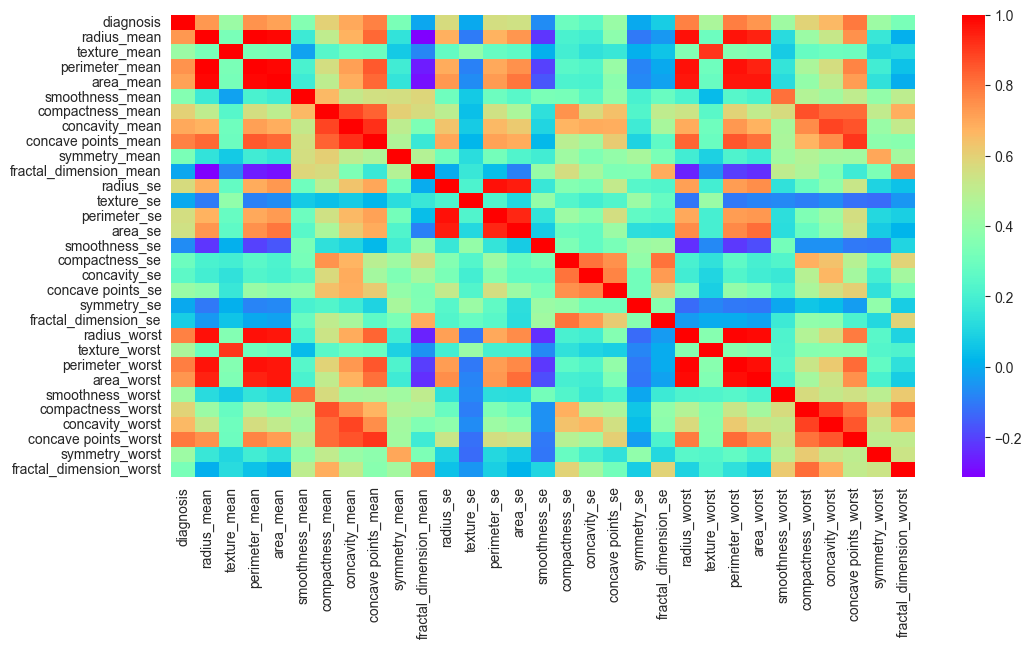

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap = 'rainbow', fmt = '.2f');

In [6]:
from sklearn.model_selection import train_test_split
y = df['diagnosis']
X = df.drop('diagnosis', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

C:\Users\renaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


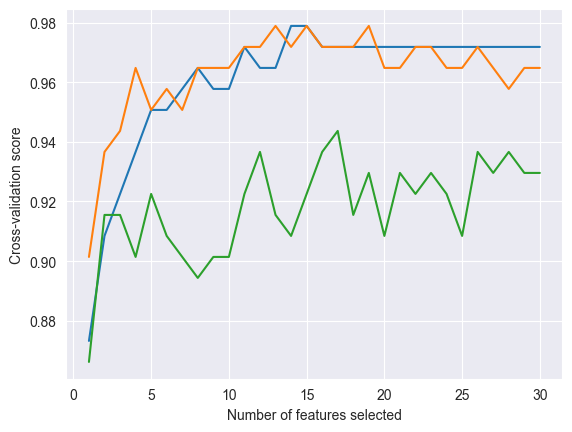

In [8]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold


random_forest = RandomForestClassifier()

rfecv = RFECV(estimator=random_forest, cv=StratifiedKFold(n_splits=3))
rfecv.fit(X_train_scaled_df, y_train)


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show();

C:\Users\renaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


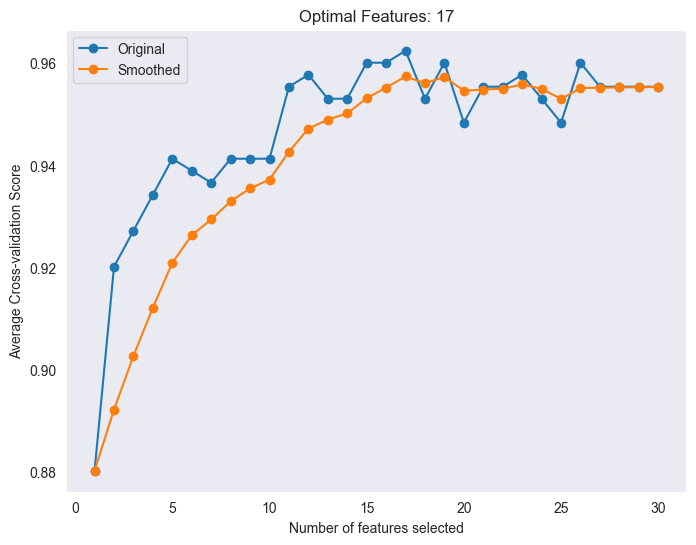

Optimal Number of Features: 17
Max Score: 0.9573998418850359


In [9]:
def smooth_curve(points, factor=0.7):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

num_features = range(1, len(rfecv.grid_scores_) + 1)
average_scores = np.mean(rfecv.grid_scores_, axis=1)
smoothed_scores = smooth_curve(average_scores, factor=0.7)


max_score_index = np.argmax(smoothed_scores)
optimal_num_features = num_features[max_score_index]
max_score = smoothed_scores[max_score_index]

plt.figure(figsize=(8, 6))
plt.plot(num_features, average_scores, marker='o', linestyle='-', label='Original')
plt.plot(num_features, smoothed_scores, marker='o', linestyle='-', label='Smoothed')
plt.xlabel("Number of features selected")
plt.ylabel("Average Cross-validation Score")
plt.title(f"Optimal Features: {optimal_num_features}")
plt.legend()
plt.grid()
plt.show()


print("Optimal Number of Features:", optimal_num_features)
print("Max Score:", max_score)

In [11]:
rfe = RFE(random_forest, n_features_to_select=17)
rfe.fit(X_train_scaled_df, y_train)

feature_selection_results = pd.DataFrame({'Feature': X_train_scaled_df.columns,
                                          'Ranking': rfe.ranking_,
                                          'Selected': rfe.support_})


sorted_results = feature_selection_results.sort_values(by='Ranking')
print(sorted_results)

                    Feature  Ranking  Selected
0               radius_mean        1      True
21            texture_worst        1      True
22          perimeter_worst        1      True
23               area_worst        1      True
24         smoothness_worst        1      True
28           symmetry_worst        1      True
13                  area_se        1      True
25        compactness_worst        1      True
26          concavity_worst        1      True
10                radius_se        1      True
7       concave points_mean        1      True
6            concavity_mean        1      True
3                 area_mean        1      True
2            perimeter_mean        1      True
1              texture_mean        1      True
27     concave points_worst        1      True
20             radius_worst        1      True
12             perimeter_se        2     False
5          compactness_mean        3     False
19     fractal_dimension_se        4     False
4           s

In [12]:
selected_features = sorted_results[sorted_results['Selected'] == True]['Feature']

selected_feature_names = selected_features.tolist()

<AxesSubplot:>

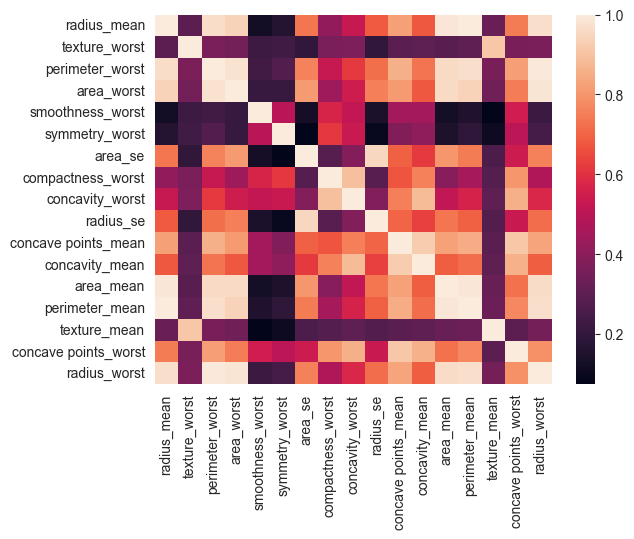

In [13]:
sns.heatmap(df[selected_feature_names].corr(), annot = False)

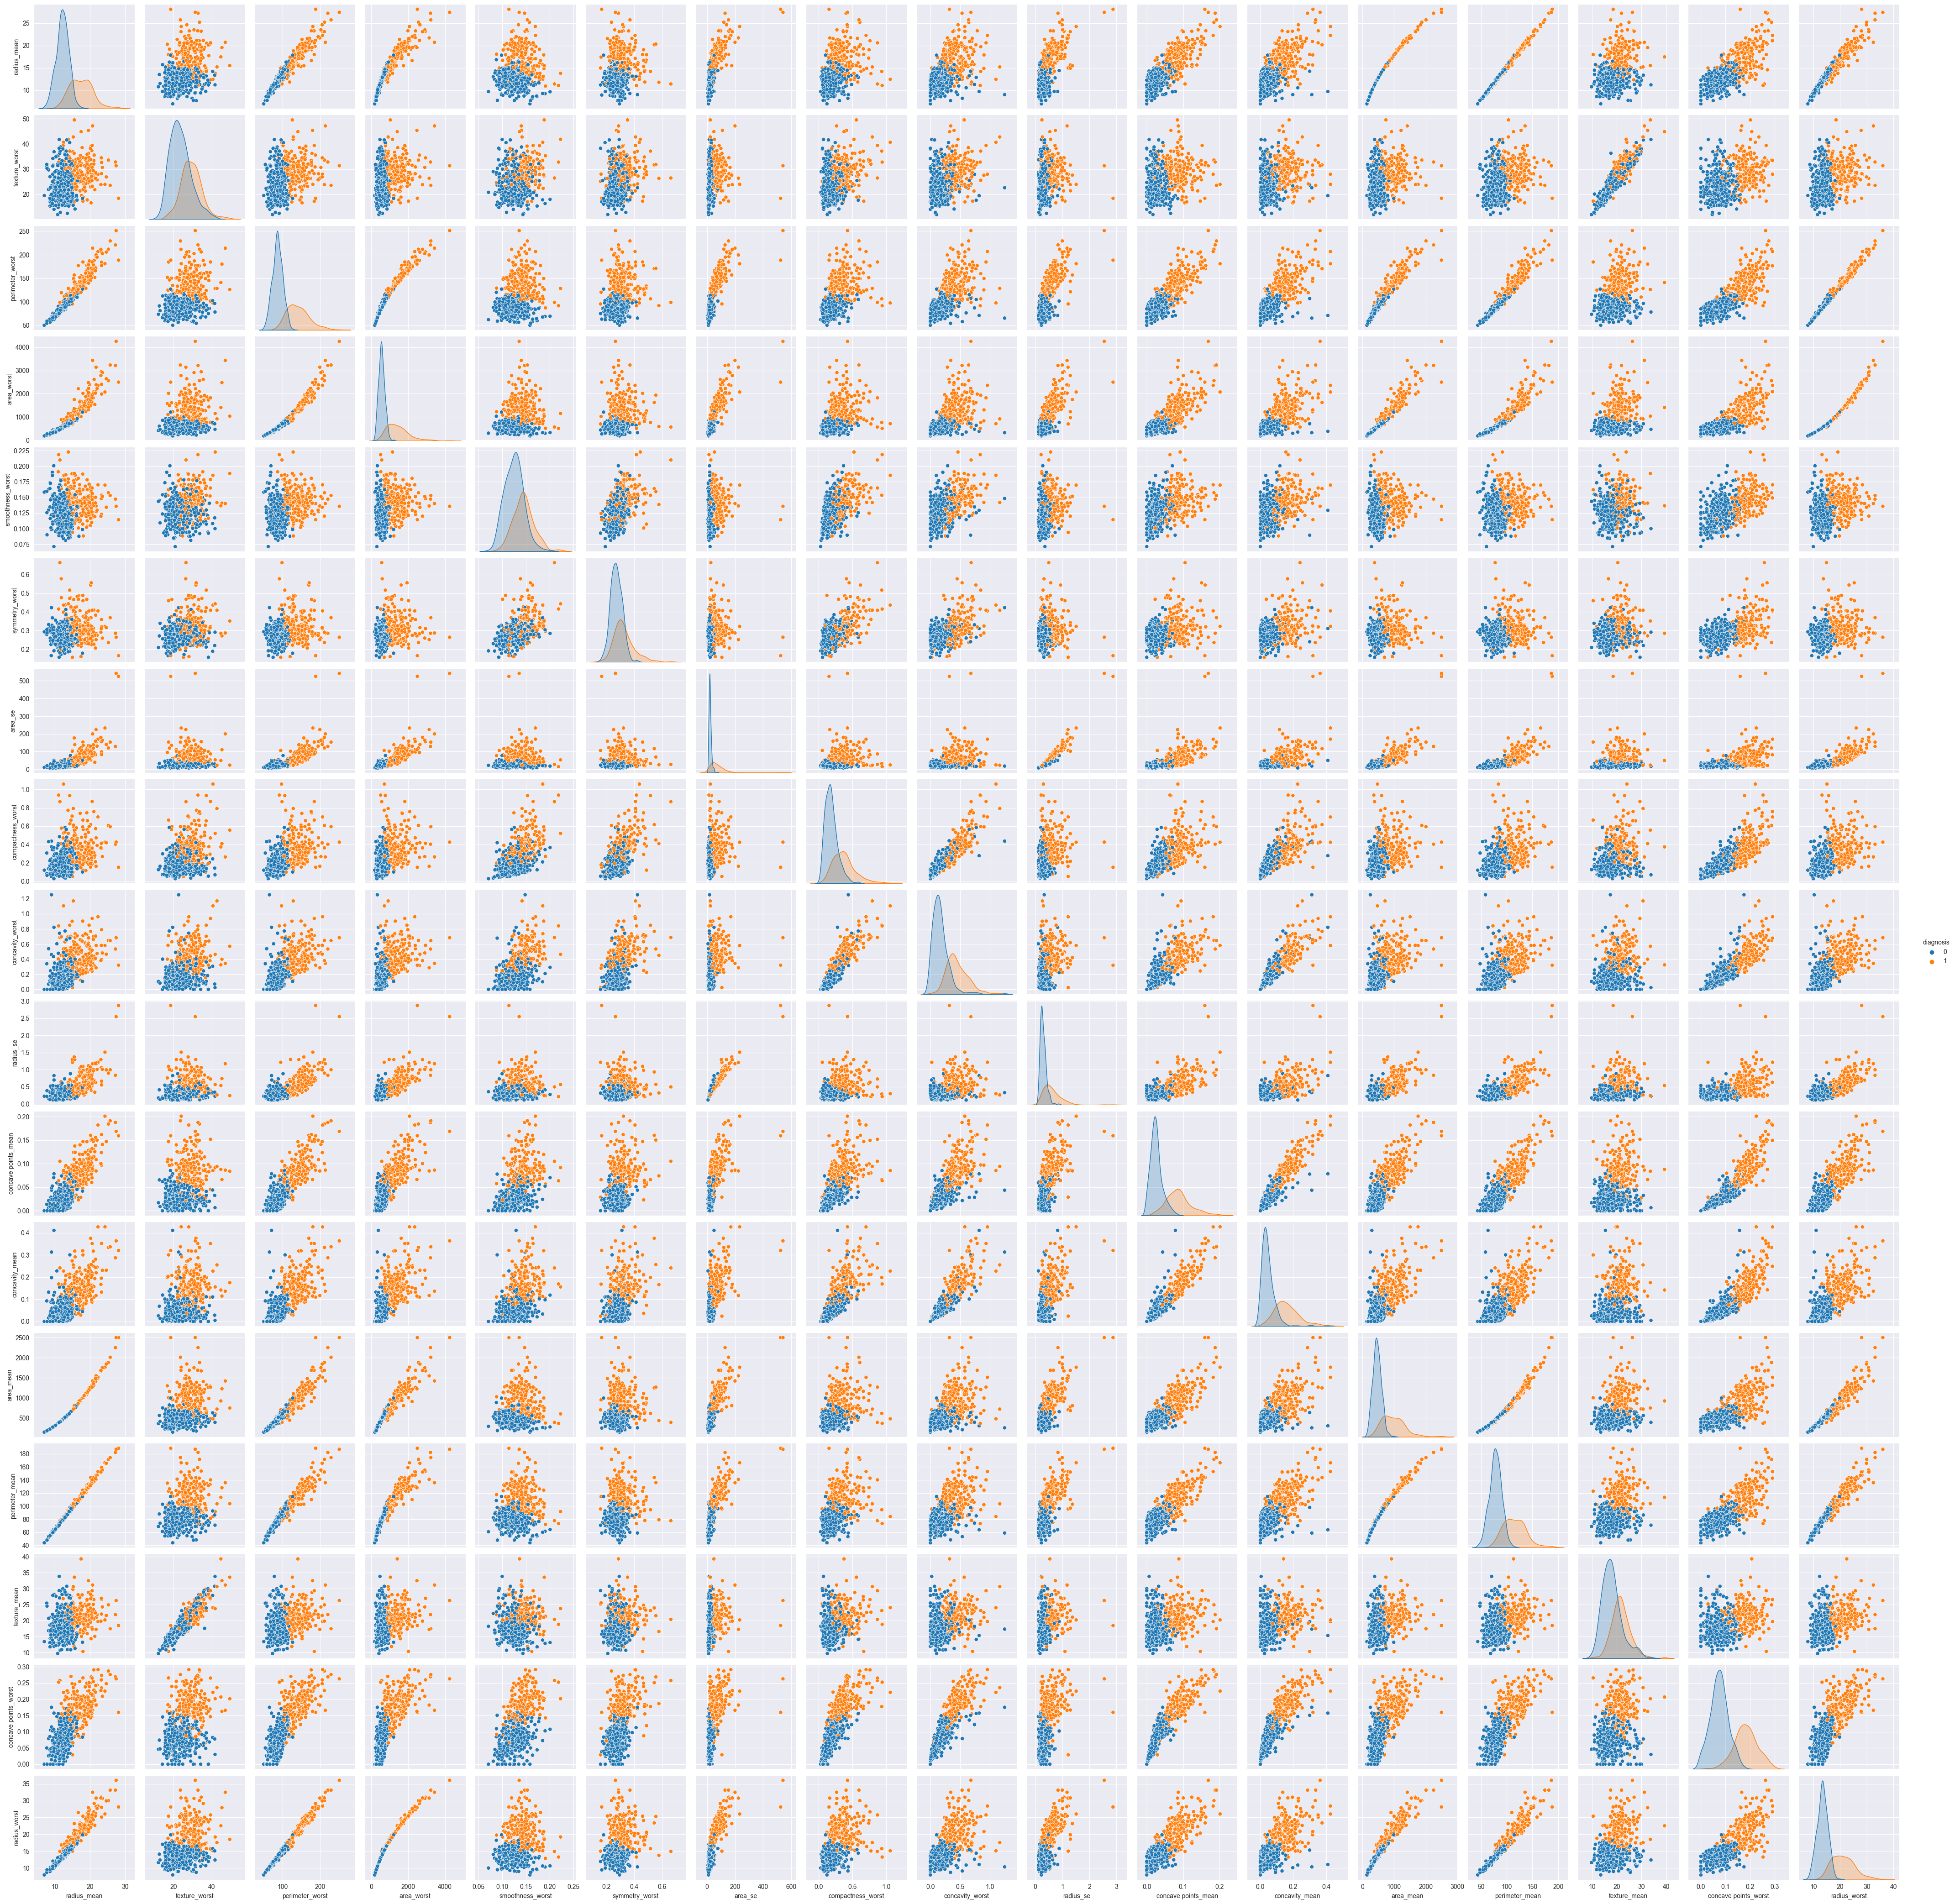

In [14]:
data_to_plot = df[selected_feature_names+['diagnosis']]

sns.pairplot(data_to_plot, hue = 'diagnosis')

# KNN

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1,21),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', cv=5)

random_search.fit(X_train_scaled_df[selected_feature_names],y_train);

In [16]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(best_params)

{'weights': 'distance', 'p': 1, 'n_neighbors': 5}


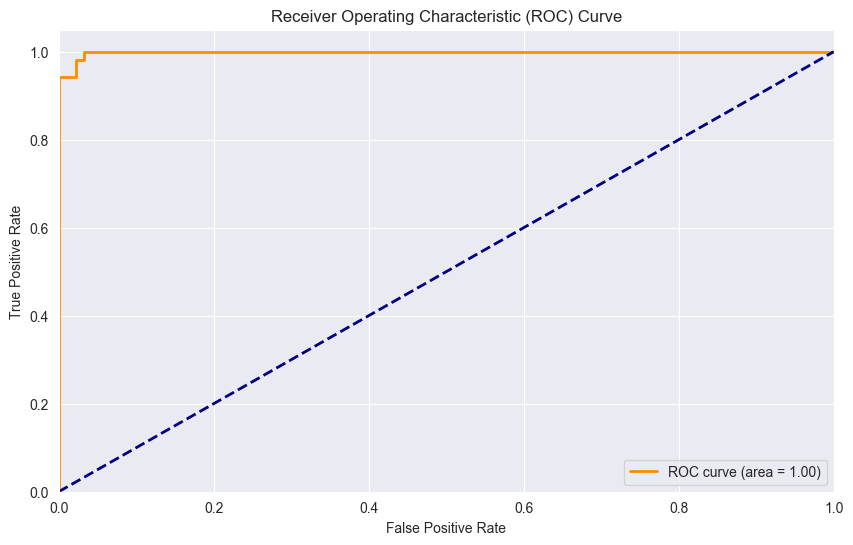

Metrics:
Recall: 0.9433962264150944
Precision: 1.0
F1-Score: 0.970873786407767
ROC AUC: 0.9985324947589099


In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve, auc


y_true = y_test
y_prob = best_model.predict_proba(X_test_scaled_df[selected_feature_names])[:, 1]
y_pred = best_model.predict(X_test_scaled_df[selected_feature_names])

fpr, tpr, thresholds = roc_curve(y_true, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


def print_classification_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    print("Metrics:")
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-Score:", f1)
    print("ROC AUC:", roc_auc)

print_classification_metrics(y_pred, y_test)


# SVM

In [20]:
from sklearn.svm import SVC

param_grid_svm =\
    {
        "C": [1e0, 1e1, 1e2, 1e3],
        "gamma": np.logspace(-2,2,5),
        "kernel": ["rbf", "poly", "sigmoid"],
    }

svc = SVC()


random_search_svm = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid_svm,
    scoring='accuracy',
    cv=3,
    n_iter=10)
random_search_svm.fit(X_train_scaled_df[selected_feature_names],y_train)


best_estimator = random_search_svm.best_estimator_
best_params = random_search_svm.best_params_

In [21]:
y_pred = best_estimator.predict(X_test_scaled_df[selected_feature_names])

print_classification_metrics(y_pred, y_test)

Metrics:
Recall: 0.9811320754716981
Precision: 1.0
F1-Score: 0.9904761904761905
ROC AUC: 0.9985324947589099
